<a href="https://colab.research.google.com/github/Yash-Shindey/jupyternotebooks/blob/main/Pretrained%20Keras%20Traffic%20Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt

import zipfile
import requests
import glob as glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from dataclasses import dataclass

from zipfile import ZipFile
from urllib.request import urlretrieve

In [2]:
SEED_VALUE = 41

# Fix seed to make training deterministic.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [4]:
URL = r"https://www.dropbox.com/s/uzgh5g2bnz40o13/dataset_traffic_signs_40_samples_per_class.zip?dl=1"

dataset_path   = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class")
asset_zip_path = os.path.join(os.getcwd(), "dataset_traffic_signs_40_samples_per_class.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [5]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3

    DATA_ROOT_TRAIN:  str = os.path.join(dataset_path, "Train")
    DATA_ROOT_VALID:  str = os.path.join(dataset_path, "Valid")
    DATA_ROOT_TEST:   str = os.path.join(dataset_path, "Test")
    DATA_TEST_GT:     str = os.path.join(dataset_path, "Test.csv")


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

In [6]:
train_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

valid_dataset = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID,
                                             batch_size=TrainingConfig.BATCH_SIZE,
                                             shuffle=True,
                                             seed=SEED_VALUE,
                                             label_mode='int', # Use integer encoding
                                             image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                            )

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [7]:
# Display the class names from the training dataset.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


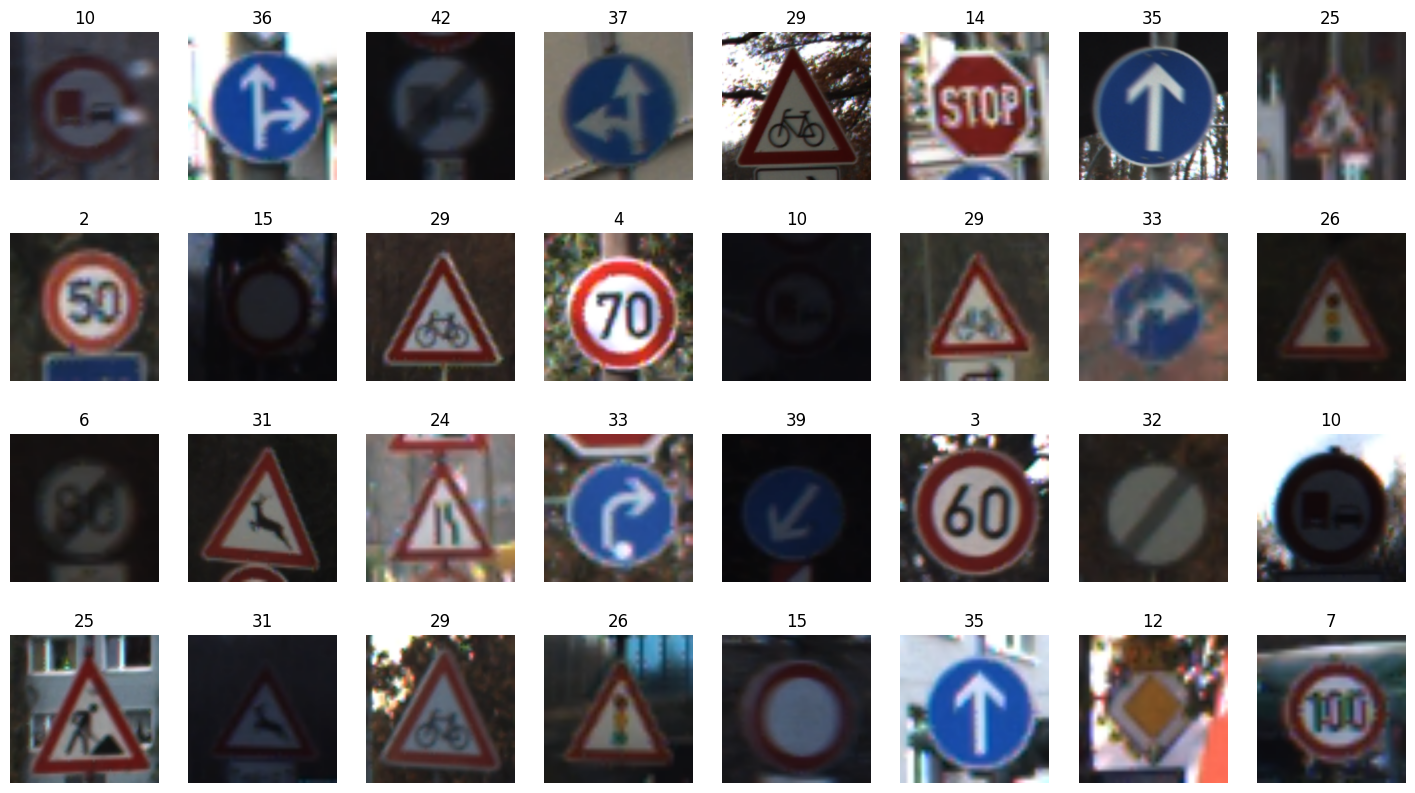

In [8]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for image_batch, labels_batch in train_dataset.take(1):
    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [9]:
import pandas as pd

input_file = DatasetConfig.DATA_TEST_GT

dataset = pd.read_csv(input_file)
df = pd.DataFrame(dataset)
cols = [6]
df = df[df.columns[cols]]
ground_truth_ids = df["ClassId"].values.tolist()
print("Total number of Test labels: ", len(ground_truth_ids))
print(ground_truth_ids[0:10])

Total number of Test labels:  12630
[16, 1, 38, 33, 11, 38, 18, 12, 25, 35]


In [10]:
# For referenece, let's print the class names from the train/valid datasets again.
print(train_dataset.class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [11]:
# Convert train/valid class names to integers.
class_names_int = list(map(int, train_dataset.class_names))

# Create a dictionary mapping ground truth IDs to class name IDs.
gtid_2_cnidx = dict(zip(class_names_int, range(0, DatasetConfig.NUM_CLASSES)))

gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [12]:
# Convert the ground truth Class IDs to IDs that correctly map to the same classes
# in the train and validation datasets.
label_ids = []
for idx in range(len(ground_truth_ids)):
    label_ids.append(gtid_2_cnidx[ground_truth_ids[idx]])

print("Original ground truth class IDs: ", ground_truth_ids[0:10])
print("New mapping required:            ", label_ids[0:10])
print("")
print("Train/Valid dataset class names: ", train_dataset.class_names)

Original ground truth class IDs:  [16, 1, 38, 33, 11, 38, 18, 12, 25, 35]
New mapping required:             [8, 1, 32, 27, 3, 32, 10, 4, 18, 29]

Train/Valid dataset class names:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [13]:
# Get all the path names to the Test images (will prune later)
image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + os.sep + "*.png"))

print(len(image_paths))
print("")
# Print the first 5 image paths to confirm.
for idx in range(5):
    print(image_paths[idx])

12630

/content/dataset_traffic_signs_40_samples_per_class/Test/00000.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00001.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00002.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00003.png
/content/dataset_traffic_signs_40_samples_per_class/Test/00004.png


In [14]:
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_ids))

In [15]:
def preprocess_image(image):
    # Decode and resize image.
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH])
    return image

In [16]:
def load_and_preprocess_image(path):
    # Read image into memory as a byte string.
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [17]:
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

In [18]:
# Apply the functions above to the test dataset.
test_dataset = test_dataset.map(load_and_preprocess_from_path_label)

# Set the batch size for the dataset.
test_dataset = test_dataset.batch(TrainingConfig.BATCH_SIZE)

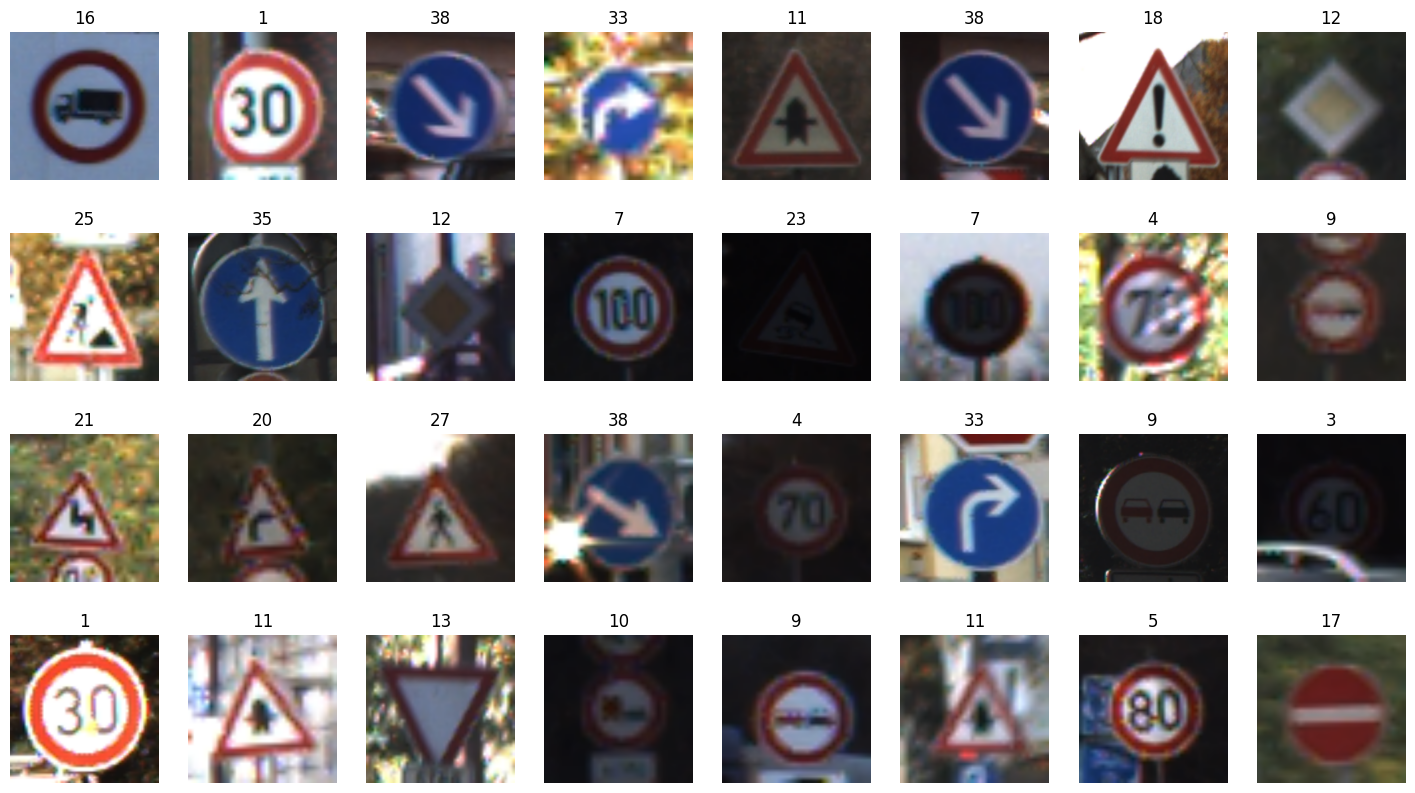

In [19]:
plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the test dataset.
for image_batch, labels_batch in test_dataset.take(1):

    # Plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        truth_idx = labels_batch[i].numpy()
        plt.title(class_names[truth_idx])
        plt.axis("off")

In [20]:
# Specify the model input shape.
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)

print('Loading model with ImageNet weights...')
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(input_shape=input_shape,
                                                    include_top=False, # We will supply our own top.
                                                    weights='imagenet',
                                                   )
vgg16_conv_base.summary()

Loading model with ImageNet weights...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Set all layers in the convolutional base to Trainable (will FREEZE initial layers further below).
vgg16_conv_base.trainable = True

# Specify the number of layers to fine tune at the end of the convolutional base.
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
num_layers = len(vgg16_conv_base.layers)

# Freeze the initial layers in the convolutional base.
for model_layer in vgg16_conv_base.layers[: num_layers - num_layers_fine_tune]:
    print(f"FREEZING LAYER: {model_layer}")
    model_layer.trainable = False

print("\n")
print(f"Configured to fine tune the last {num_layers_fine_tune} convolutional layers...")
print("\n")

vgg16_conv_base.summary()

FREEZING LAYER: <InputLayer name=input_layer, built=True>
FREEZING LAYER: <Conv2D name=block1_conv1, built=True>
FREEZING LAYER: <Conv2D name=block1_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block1_pool, built=True>
FREEZING LAYER: <Conv2D name=block2_conv1, built=True>
FREEZING LAYER: <Conv2D name=block2_conv2, built=True>
FREEZING LAYER: <MaxPooling2D name=block2_pool, built=True>
FREEZING LAYER: <Conv2D name=block3_conv1, built=True>
FREEZING LAYER: <Conv2D name=block3_conv2, built=True>
FREEZING LAYER: <Conv2D name=block3_conv3, built=True>
FREEZING LAYER: <MaxPooling2D name=block3_pool, built=True>


Configured to fine tune the last 8 convolutional layers...




Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 12,979,200 (49.51 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [22]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

# Flatten the output from the convolutional base.
x = layers.Flatten()(x)

# Add the classifier.
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# Output layer.
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation="softmax")(x)

# The final model.
model_vgg16_finetune = keras.Model(inputs, outputs)

model_vgg16_finetune.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 7, 7, 512)      │     14,714,688 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 25088)          │              0 │ vgg16[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      3,211,392 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 43)             │          5,547 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 17,931,627 (68.40 MB)

 Trainable params: 16,196,139 (61.78 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [23]:
# Use this for integer encoded labels.
model_vgg16_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [24]:
# Train the Model.
training_results = model_vgg16_finetune.fit(train_dataset,
                                            epochs=TrainingConfig.EPOCHS,
                                            validation_data=valid_dataset,
                                           )

Epoch 1/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 956ms/step - accuracy: 0.0248 - loss: 6.7565 - val_accuracy: 0.0388 - val_loss: 3.7228
Epoch 2/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.0452 - loss: 3.6740 - val_accuracy: 0.0950 - val_loss: 3.5129
Epoch 3/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.0986 - loss: 3.4554 - val_accuracy: 0.1453 - val_loss: 3.2188
Epoch 4/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.1411 - loss: 3.1743 - val_accuracy: 0.3140 - val_loss: 2.7844
Epoch 5/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - accuracy: 0.2747 - loss: 2.7149 - val_accuracy: 0.4690 - val_loss: 1.9899
Epoch 6/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step - accuracy: 0.4556 - loss: 1.9637 - val_accuracy: 0.6027 - val_loss: 1.4778
Epoch 7/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 322ms/step - accuracy: 0.6173 - loss: 1.4219 - val_accuracy: 0.7229 - val_loss: 0.9474
Epoch 8/101
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.7170 - loss: 1.0208 - 

In [25]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

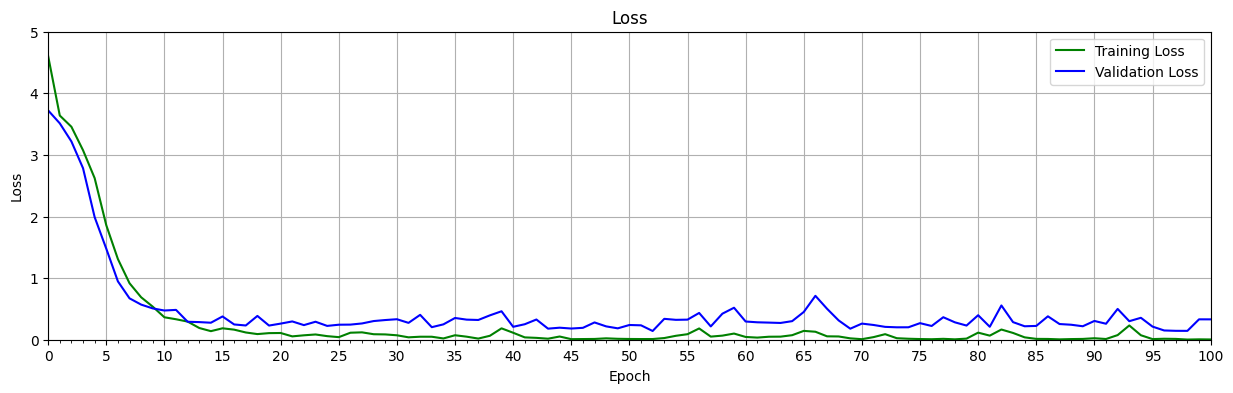

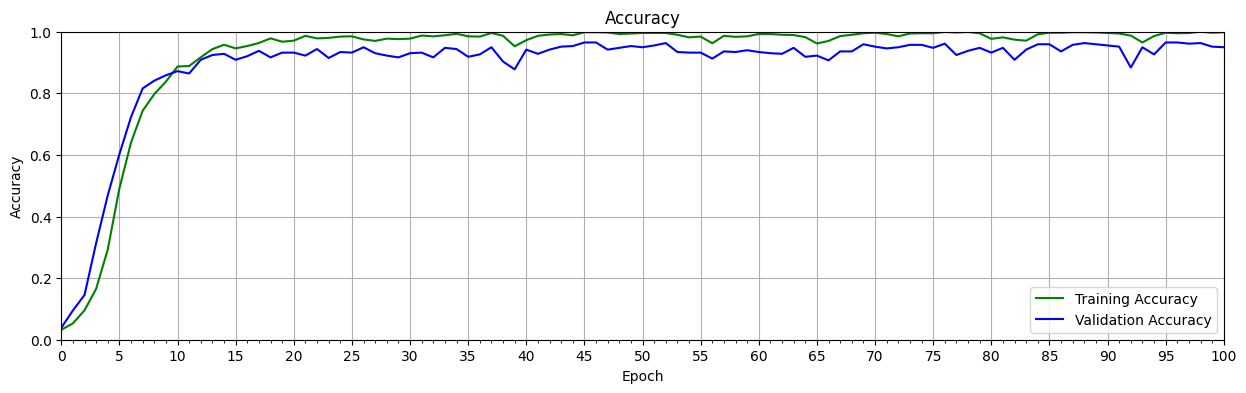

In [26]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]

plot_results(
    [train_loss, valid_loss],
    ylabel="Loss",
    ylim=[0.0, 5.0],
    metric_name=["Training Loss", "Validation Loss"],
    color=["g", "b"],
)

plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.0, 1.0],
    metric_name=["Training Accuracy", "Validation Accuracy"],
    color=["g", "b"],
)

In [27]:
print(f"Model valid accuracy: {model_vgg16_finetune.evaluate(valid_dataset)[1]*100.:.3f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9460 - loss: 0.3155
Model valid accuracy: 94.961


In [28]:
print(f"Model test accuracy: {model_vgg16_finetune.evaluate(test_dataset)[1]*100.:.3f}")

395/395 ━━━━━━━━━━━━━━━━━━━━ 68s 172ms/step - accuracy: 0.9611 - loss: 0.2438
Model test accuracy: 96.033


In [29]:
def display_predictions(dataset, model, class_names):

    plt.figure(figsize=(20, 20))
    num_rows = 8
    num_cols = 8
    jdx = 0

    # Evaluate two batches.
    for image_batch, labels_batch in dataset.take(2):
        print(image_batch.shape)

        # Predictions for the current batch.
        predictions = model.predict(image_batch)

        # Loop over all the images in the current batch.
        for idx in range(len(labels_batch)):
            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = labels_batch[idx].numpy()

            # Set the title color based on the prediction.
            if pred_idx == truth_idx:
                color = "g"
            else:
                color = "r"

            jdx += 1

            if jdx > num_rows * num_cols:
                # Break from the loops if the maximum number of images have been plotted
                break

            ax = plt.subplot(num_rows, num_cols, jdx)
            title = str(class_names[truth_idx]) + " : " + str(class_names[pred_idx])

            title_obj = plt.title(title)
            plt.setp(title_obj, color=color)
            plt.axis("off")
            plt.imshow(image_batch[idx].numpy().astype("uint8"))
    return

(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


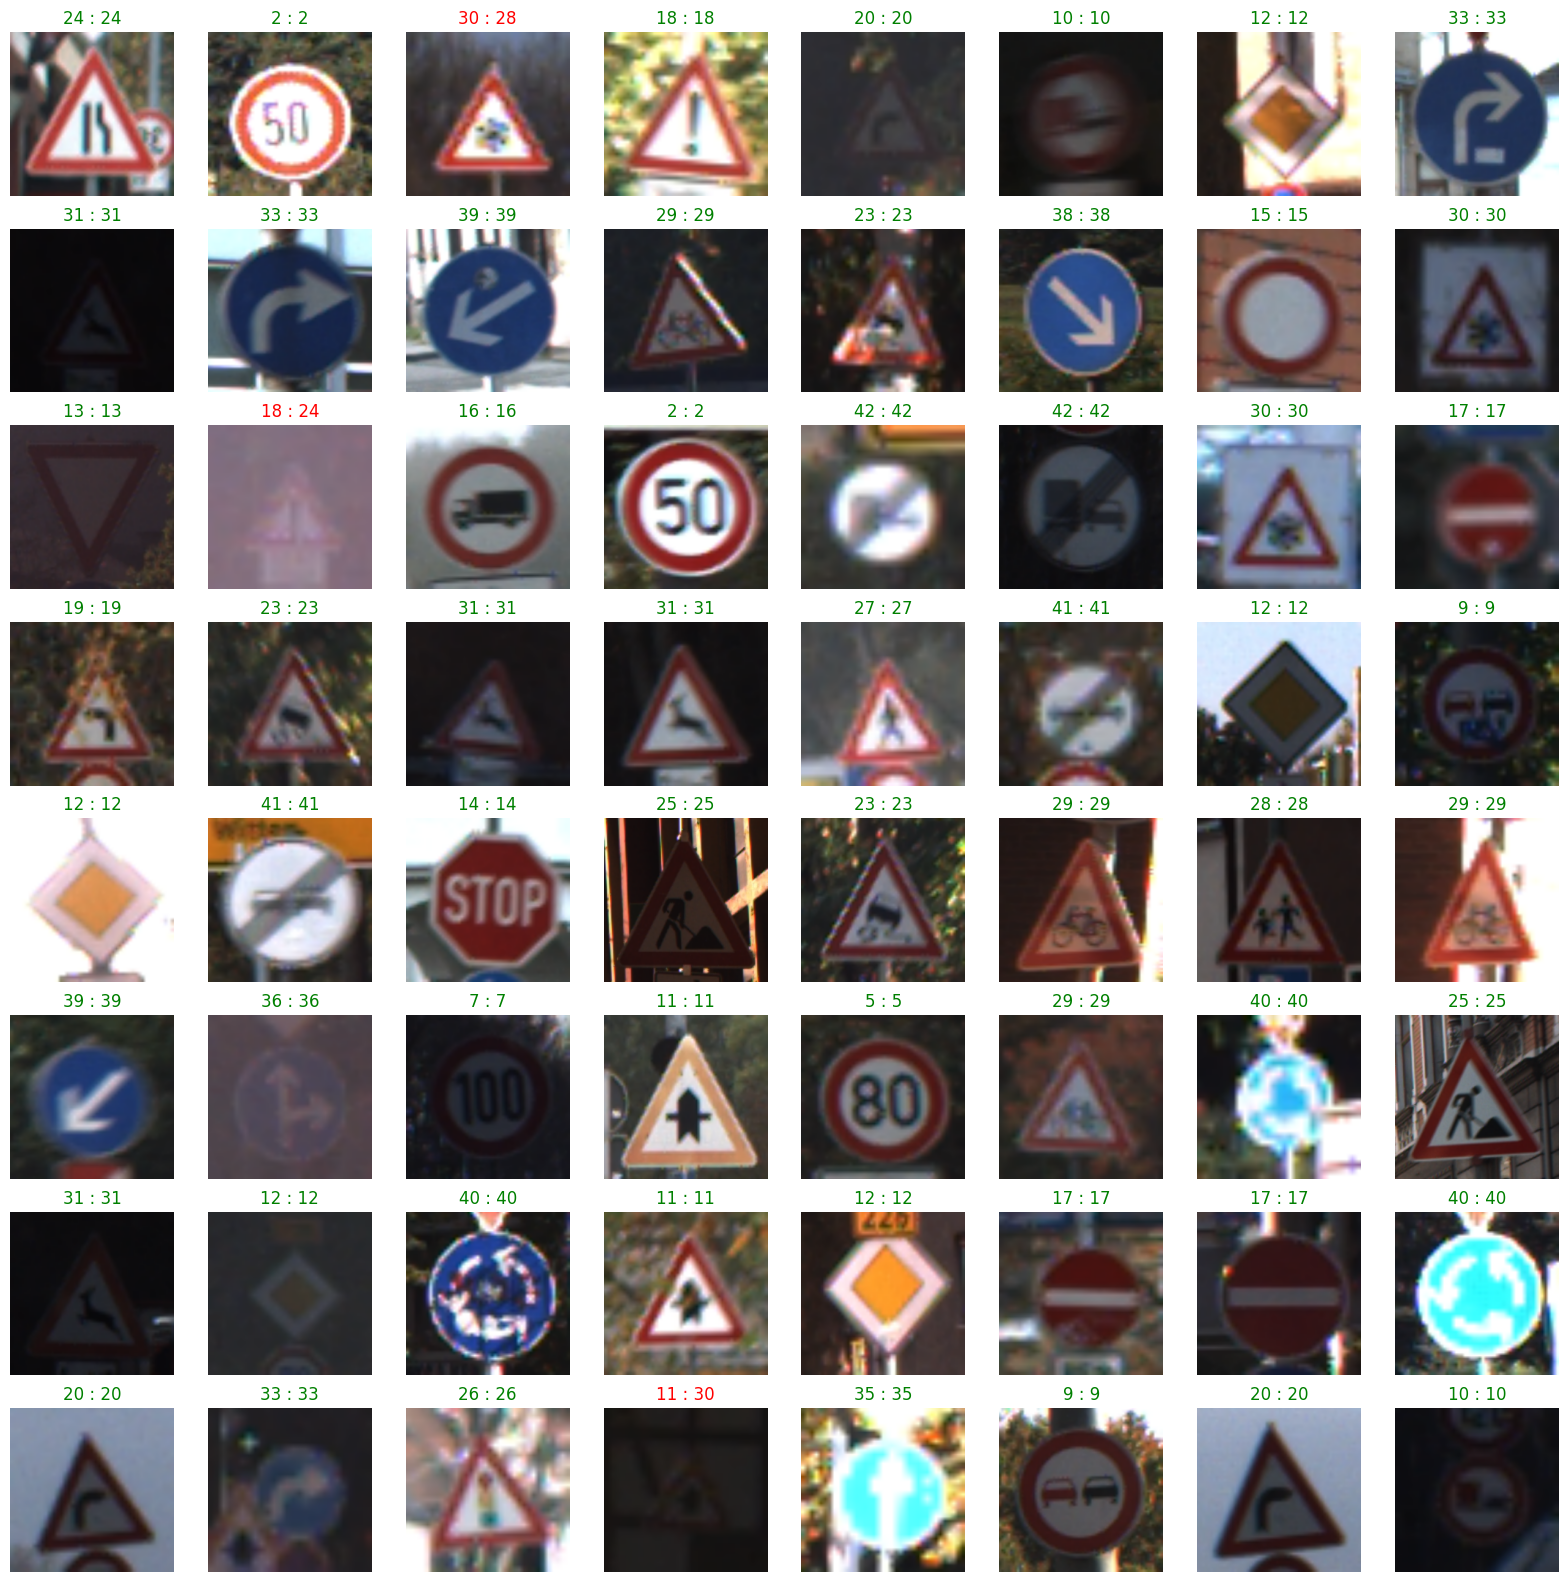

In [30]:
display_predictions(valid_dataset, model_vgg16_finetune, class_names)

(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(32, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


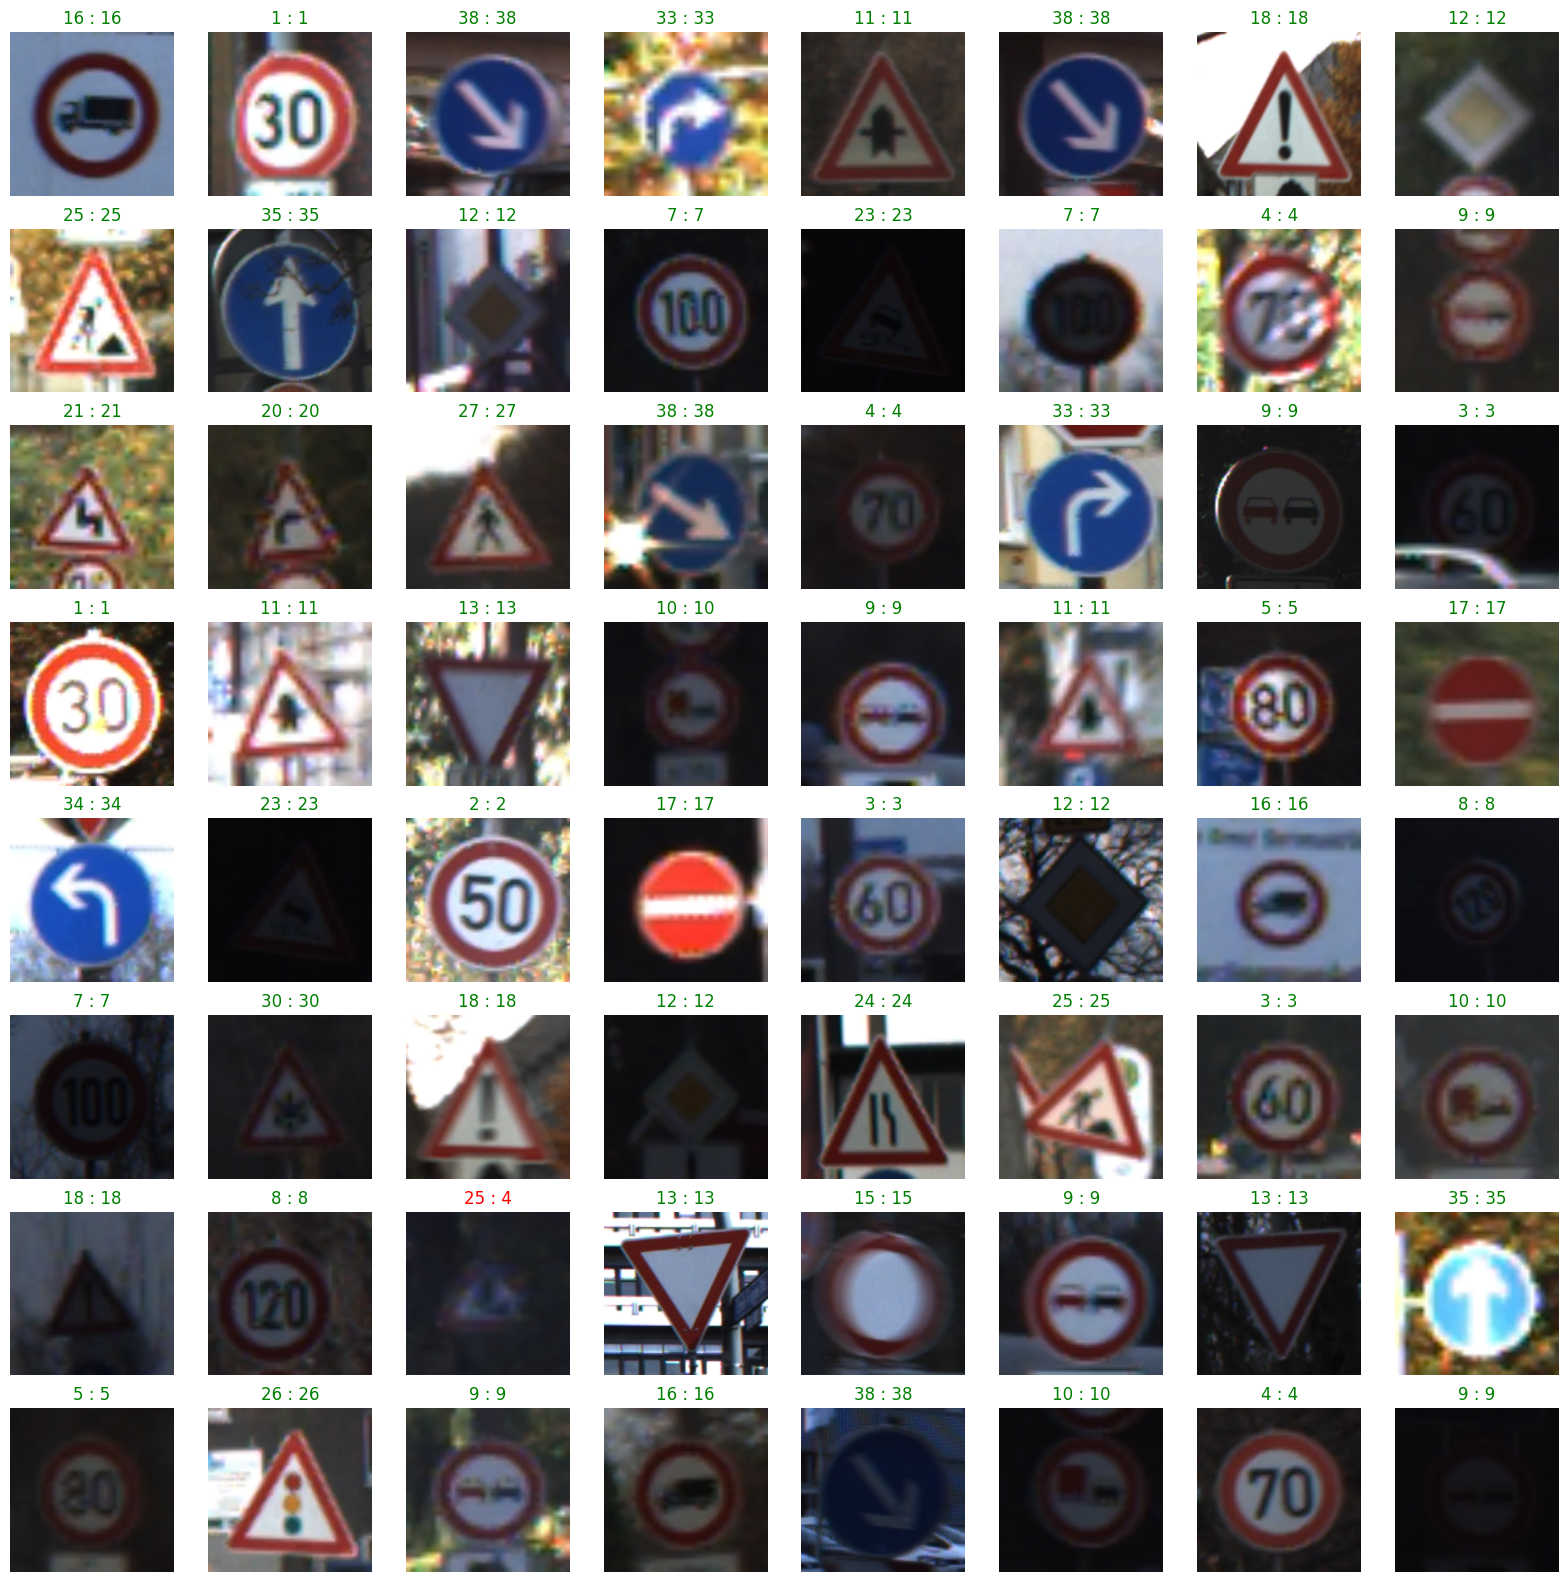

In [31]:
display_predictions(test_dataset, model_vgg16_finetune, class_names)